In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import MinMaxScaler

In [2]:
synsets = list(swn.senti_synsets('play', 'n'))

In [3]:
for syn in synsets:
    print(syn.synset.definition())

a dramatic work intended for performance by actors on a stage
a theatrical performance of a drama
a preset plan of action in team sports
a deliberate coordinated movement requiring dexterity and skill
a state in which action is feasible
utilization or exercise
an attempt to get something
activity by children that is guided more by imagination than by fixed rules
(in games or plays or other performances) the time during which play proceeds
the removal of constraints
a weak and tremulous light
verbal wit or mockery (often at another's expense but not to be taken seriously)
movement or space for movement
gay or light-hearted recreational activity for diversion or amusement
(game) the activity of doing something in an agreed succession
the act of playing for stakes in the hope of winning (including the payment of a price for a chance to win a prize)
the act using a sword (or other weapon) vigorously and skillfully


In [4]:
yelp_file = 'data/yelp_example_1.json'
with open(yelp_file, 'r') as infile:
    data = json.load(infile)

In [5]:
docs = data['docs']
titles = data['titles']
scores = data['scores']

In [6]:
scores[:10]

[1, 5, 2, 5, 5, 5, 1, 4, 5, 3]

In [25]:
binary_scores = np.zeros(len(scores))
for i, score in enumerate(scores):
    if score > 3:
        binary_scores[i] = 1
    elif score < 3:
        binary_scores[i] = -1
    else:
        pass

In [7]:
text = docs[0]

In [8]:
for token, pos in text:
    synsets = list(swn.senti_synsets(token))
    print(token, len(synsets))

place 32
be 14
price 9
generic 5
cuisine 1
serve 16
aside 8
food 3
be 14
only 9
room 5
temperature 2
be 14
much 7
well 22
spend 3
dollar 4
least 3
there 4
have 20
decent 7
assortment 2
sushi 1
standard 11
mongolian 4
bbq 0


## Exercise 1: develop a strategy to score the text
Just ignore POS for the time being

### Answer 1: simple sum

In [33]:
def all_synsets(text):
    return [list(swn.senti_synsets(token)) for token, pos in text]

In [55]:
def sum_strategy(text):
    s = np.zeros(3)
    all_s = all_synsets(text)
    for i, (token, pos) in enumerate(text):
        try:
            synsets = all_s[i]
            sidf = np.log(max([len(l) for l in all_s]) / len(synsets))
            for syn in synsets:
                p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                s[0] += p * sidf
                s[1] += n * sidf
                s[2] += o * sidf
        except ZeroDivisionError:
            pass
    return s

In [56]:
Xd = {}
for i, text in enumerate(docs):
    Xd[i] = sum_strategy(text)

In [57]:
X = pd.DataFrame(Xd).T
X.columns = ['p', 'n', 'o']

In [58]:
X.head()

,p,n,o
0,8.764527,1.495315,45.069068
1,6.421661,4.209033,19.978630
2,3.340230,2.569615,24.257568
3,6.099879,0.416857,18.051018
4,11.228233,3.220464,20.117627


In [59]:
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

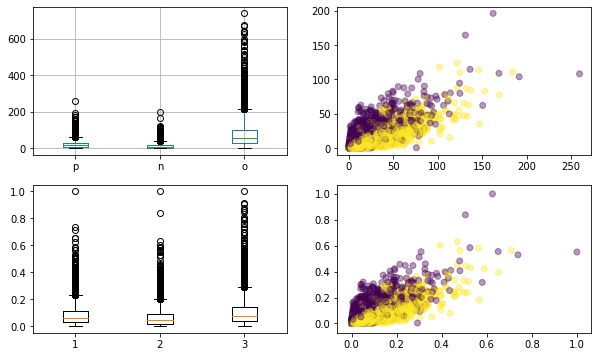

In [60]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
X.boxplot(ax=ax[0,0])
ax[0,1].scatter(X.p, X.n, alpha=0.4, c=y_true)
ax[1,0].boxplot(Xs)
ax[1,1].scatter(Xs[:,0], Xs[:,1], alpha=0.4, c=y_true)
plt.show()

In [61]:
p = Xs.argmax(axis=1)
y_pred = np.zeros(len(scores))
for i, s in enumerate(p):
    if s == 0:
        y_pred[i] = 1

In [62]:
y_true = np.zeros(len(scores))
for i, s in enumerate(scores):
    if s >= 4:
        y_true[i] = 1

In [63]:
y_true

array([0., 1., 0., ..., 1., 0., 1.])

In [64]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [66]:
report = classification_report(y_true, y_pred)

In [67]:
print(report)

              precision    recall  f1-score   support

         0.0       0.41      0.84      0.55      1658
         1.0       0.84      0.41      0.55      3342

    accuracy                           0.55      5000
   macro avg       0.62      0.62      0.55      5000
weighted avg       0.70      0.55      0.55      5000



In [68]:
cm = confusion_matrix(y_true, y_pred)

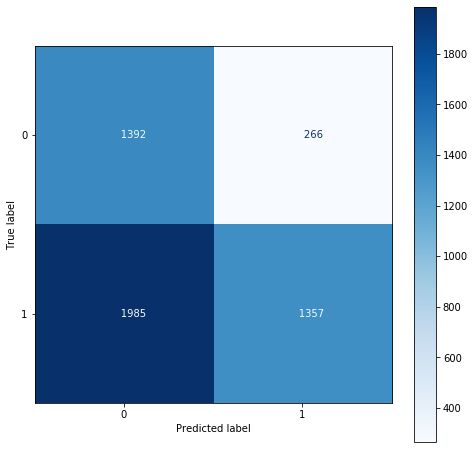

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))
d = ConfusionMatrixDisplay(cm, [0, 1])
d.plot(cmap=plt.cm.Blues, ax=ax, values_format='10.0f')
plt.show()